In [1]:
import numpy as np
import pandas as pd
import ta
import scipy.stats
from datetime import datetime
import math
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import yfinance as yf

In [2]:
from sklearn.mixture import GaussianMixture

In [3]:
def preprocessing_yf(symbol,period=None,interval=None):
    global df
 #Import data
    print(period,interval)
    if period:
        if interval:
            df = yf.download(symbol,period=period,interval=interval).dropna()
        else:
            df = yf.download(symbol,period=period).dropna()
    else:
        if interval:
            df = yf.download(symbol,interval=interval).dropna()
        else:
            df = yf.download(symbol).dropna()

 #Rename
    df.columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df.index.name = "Date"

    #Remove adj close
    # del df["adj close"]

    return df

In [4]:
df = preprocessing_yf("AAPL",None,None)
df = df.rename_axis('Date').reset_index()
df.head()

None None


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10926,2024-04-17,169.610001,170.649994,168.000000,168.000000,168.000000,50901200
10927,2024-04-18,168.029999,168.639999,166.550003,167.039993,167.039993,43122900
10928,2024-04-19,166.210007,166.399994,164.080002,165.000000,165.000000,67772100
10929,2024-04-22,165.520004,167.259995,164.770004,165.839996,165.839996,48116400
10930,2024-04-23,165.259995,167.050003,164.929993,166.899994,166.899994,48868033


In [6]:
df = ta.add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
df['date'] = df['Date'].apply(lambda x: datetime.strptime(str(x)[0:13],"%Y-%m-%d %H"))

# Slow : 60+
# Fast : 15

df.columns[25:]

Index(['volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_r

In [7]:
# Feature Vector Calculations.
df['priceChange'] = df['Close']-df['Open']
df['priceChange_p'] = (df['Close']-df['Open'])/df['Open']

class_threshold = 0
df['classPriceChange'] = 1*(df['priceChange']>class_threshold)

df['dateInt'] = df['date'].apply(lambda x: (x - datetime(1970,1,1)).days)
df['close_r20'] = df.Close.rolling(20).mean()
df['close_r200'] = df.Close.rolling(200).mean()
df['APO_momentum'] = df['close_r20']-df['close_r200']
df['BOP'] = ((df['Close']-df['Open'])/(df['High']-df['Low'])).rolling(14).mean()
#df['CMO'] = chande_momentum_oscillator(df['Close'],period=20)
df['Momentum_10'] = df["Close"]-df["Close"].shift(10)

# Fast SMA is 12 days
# Slow EMA is 26 days

df['medPrice'] = ((df['High']+df['Low'])/2)
df['typPrice'] = ((df['High']+df['Low']+df['Close'])/3)
df['wtyPrice'] = ((df['High']+df['Low']+2*df['Close'])/3)

/var/folders/1l/b0z4mmbn7xv8h151fgmnr_j40000gv/T/ipykernel_33514/2114057051.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['typPrice'] = ((df['High']+df['Low']+df['Close'])/3)
/var/folders/1l/b0z4mmbn7xv8h151fgmnr_j40000gv/T/ipykernel_33514/2114057051.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['wtyPrice'] = ((df['High']+df['Low']+2*df['Close'])/3)


<Axes: title={'center': 'Daily AAPL Closing Prices in 2023 (1-Day Period)'}, xlabel='Date', ylabel='Closing Price'>

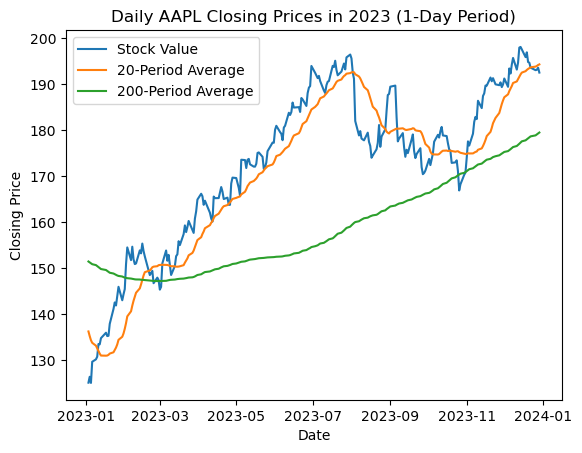

In [8]:
#sns.scatterplot(data=df_subset,x="date",y="Close",hue="classPriceChange")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Day Mode
df_subset = df[(df['date']>np.datetime64('2022-12-31'))&(df['date']<np.datetime64('2024-01-01'))].reset_index(drop=True)

ax = sns.lineplot(data=df_subset,x="date",y="Close",label="Stock Value")
ax.set_title("Daily AAPL Closing Prices in 2023 (1-Day Period)")
plt.xlabel("Date")
plt.ylabel("Closing Price")

sns.lineplot(data=df_subset,x="date",y="close_r20",label="20-Period Average")
sns.lineplot(data=df_subset,x="date",y="close_r200",label="200-Period Average")

Text(0, 0.5, 'Closing Price')

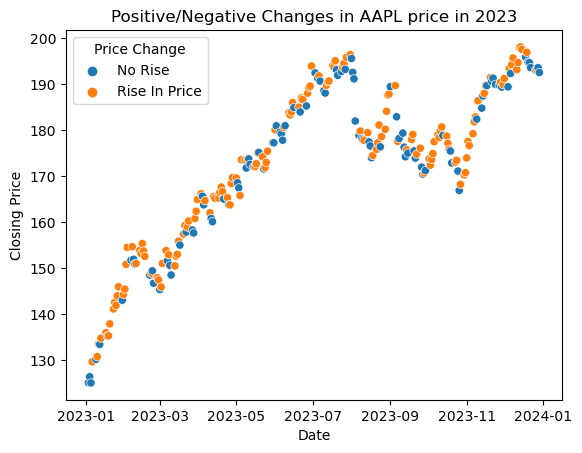

In [9]:
df_subset = df[(df['date']>np.datetime64('2022-12-31'))&(df['date']<np.datetime64('2024-01-01'))].reset_index(drop=True)

df_subset['Price Change'] = ["Rise In Price" if x==1 else "No Rise" for x in df_subset["classPriceChange"]]
ax = sns.scatterplot(data=df_subset,x="date",y="Close",hue='Price Change')
ax.set_title("Positive/Negative Changes in AAPL price in 2023")
plt.xlabel("Date")
plt.ylabel("Closing Price")

In [10]:
# known_vars
cols_dont_shift = ['classPriceChange','priceChange','priceChange_p','date','Date','dateInt']
cols_shift = [x for x in df.columns if x not in cols_dont_shift]

df2 = pd.concat(
    [
        df[['classPriceChange','priceChange','date','Date','dateInt']],
        df[list(df.columns[7:93])].shift(1),
        #df[['priceChange_p']].shift(1),
        df[list(df.columns[-9:])].shift(1),
    ],
    axis=1).dropna()

df2.head()
print(df2.iloc[:,1:5])

       priceChange       date       Date  dateInt
200       0.000000 1981-09-29 1981-09-29     4289
201       0.000000 1981-09-30 1981-09-30     4290
202       0.000000 1981-10-01 1981-10-01     4291
203       0.000000 1981-10-02 1981-10-02     4292
204       0.000000 1981-10-05 1981-10-05     4295
...            ...        ...        ...      ...
10926    -1.610001 2024-04-17 2024-04-17    19830
10927    -0.990005 2024-04-18 2024-04-18    19831
10928    -1.210007 2024-04-19 2024-04-19    19832
10929     0.319992 2024-04-22 2024-04-22    19835
10930     1.639999 2024-04-23 2024-04-23    19836

[10539 rows x 4 columns]


In [11]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
all_x = df2[df2.columns[4:]].values
all_y = df2['classPriceChange'].values

custom_mask = np.array(list(map(lambda x: x<np.datetime64('2020-01-01'),df2['date'].values)))
train_x = all_x[custom_mask]
train_y = all_y[custom_mask]
test_x = all_x[~custom_mask]
test_y = all_y[~custom_mask]

In [12]:
print([x for x in range(0,12)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Smallest N with at least 95% variance retained:	 23


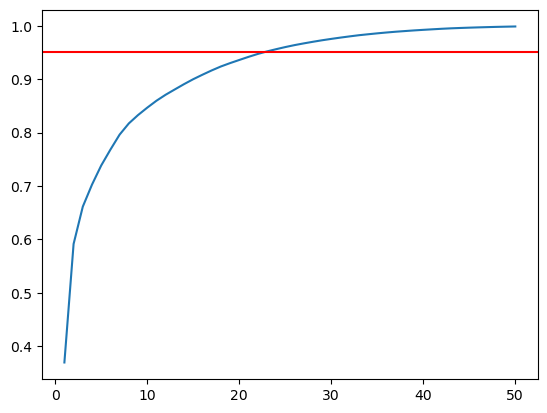

In [13]:
n_options = [x+1 for x in range(50)]
scores = []
for n in n_options:
    myPipeline_PRE = Pipeline([
        ('scaler', StandardScaler()),
        ('pca',PCA(n_components=n))])
    myPipeline_PRE.fit(train_x)
    scores.append(np.sum(myPipeline_PRE['pca'].explained_variance_ratio_))

best_n = n_options[np.argmax([x>=.95 for x in scores])]

print("Smallest N with at least 95% variance retained:\t",best_n)
plt.plot(n_options,scores)
plt.axhline(y = 0.95, color = 'r', linestyle = '-') 

In [14]:
# Preprocessing

myPipeline_PRE = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',PCA(n_components=best_n))])

train_xD = myPipeline_PRE.fit_transform(train_x)
test_xD = myPipeline_PRE.fit_transform(test_x)

train_xD_1 = train_xD[train_y==1]
train_xD_0 = train_xD[train_y==0]

print("Train Data, y==1:\t",train_xD_1.shape)
print("Train Data, y==0:\t",train_xD_0.shape)

Train Data, y==1:	 (4426, 23)
Train Data, y==0:	 (5029, 23)


Best Parameter Selected:	: {'mix__n_components': 10}


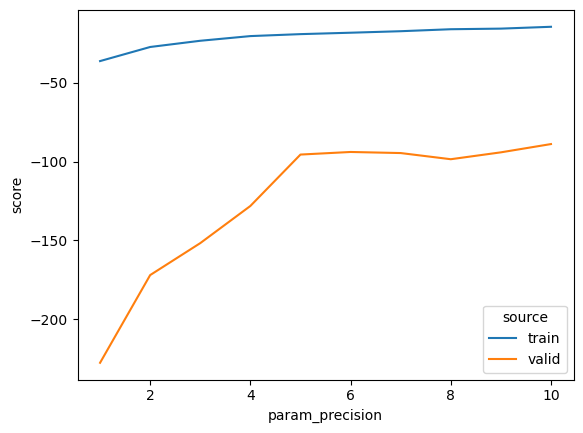

In [15]:
myPipeline_MIX = Pipeline([
    ('mix', GaussianMixture())])

parameter_grid_MIX = {
    'mix__n_components':[x for x in range(1,11)]
}

clf_M1 = GridSearchCV(myPipeline_MIX,
                   parameter_grid_MIX,
                   cv = 5,
                   return_train_score=True)
clf_M1.fit(train_xD_1)

param_precision = clf_M1.cv_results_['param_mix__n_components'].data

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'components':param_precision,
     'score':clf_M1.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'param_precision':param_precision,
     'score':clf_M1.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="param_precision",y='score',hue="source")

print("Best Parameter Selected:\t:",clf_M1.best_params_)

Best Parameter Selected:	: {'mix__n_components': 4}


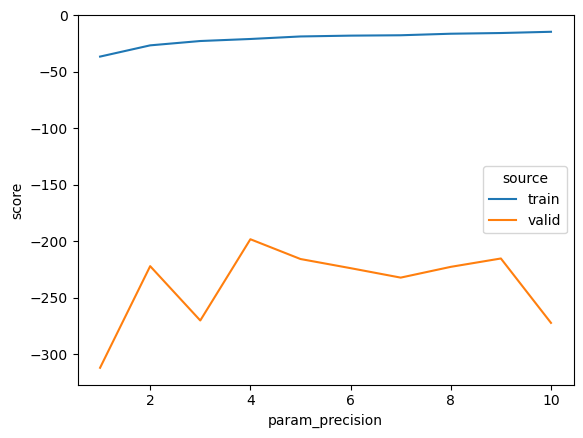

In [16]:
clf_M0 = GridSearchCV(myPipeline_MIX,
                   parameter_grid_MIX,
                   cv = 5,
                   return_train_score=True)
clf_M0.fit(train_xD_0)

param_precision = clf_M0.cv_results_['param_mix__n_components'].data

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'components':param_precision,
     'score':clf_M0.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'param_precision':param_precision,
     'score':clf_M0.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="param_precision",y='score',hue="source")

print("Best Parameter Selected:\t:",clf_M0.best_params_)

In [17]:
pi0 = clf_M0.best_estimator_['mix'].weights_
mu0 = clf_M0.best_estimator_['mix'].means_
cov0 = clf_M0.best_estimator_['mix'].covariances_
pi1 = clf_M1.best_estimator_['mix'].weights_
mu1 = clf_M1.best_estimator_['mix'].means_
cov1 = clf_M1.best_estimator_['mix'].covariances_
p1 = np.mean(train_y)

param_tuple = (p1,pi0,pi1,mu0,mu1,cov0,cov1)

In [35]:
# P(X,Y=1) = P(Y=1) P(X|Y=1) / P(X)
#          = P(Y=1) SUM P(Z)P(X|Z,Y=1) / P(X)
#          = P(Y=1) SUM P(Z)P(X|Z,Y=1) / ( P(Y=1) P(X|Y=1) + P(Y=0) P(X|Y=0))
#          = P(Y=1) SUM P(Z)P(X|Z,Y=1) / ( P(Y=1) SUM P(Z) P(X|Z,Y=1) + P(Y=0) SUM P(Z) P(X|Z,Y=0))

#x_D = train_xD_0[0]
#x_D = train_xD_1[0]

def prob_gmm_joint_xy(x_D, param_tuple):
    p1, pi0, pi1, mu0, mu1, cov0, cov1 = param_tuple
    
    K0 = pi0.shape[0]
    K1 = pi1.shape[0]
    
    pdf_z0 = np.array(list(map(
                        lambda k: scipy.stats.multivariate_normal.pdf(x_D,mu0[k],cov0[k]),
                        range(K0)
    )))
    num_z0 = (1-p1)*np.sum(pi0*pdf_z0)
    
    pdf_z1 = np.array(list(map(
                        lambda k: scipy.stats.multivariate_normal.pdf(x_D,mu1[k],cov1[k]),
                        range(K1)
    )))
    num_z1 = p1*np.sum(pi1*pdf_z1)
    p_x = num_z0+num_z1
    
    return [num_z0/p_x,num_z1/p_x]

train_predict1_y = np.array(list(map(lambda x: prob_gmm_joint_xy(x,param_tuple), train_xD_1)))
train_predict0_y = np.array(list(map(lambda x: prob_gmm_joint_xy(x,param_tuple), train_xD_0)))
test_predict_y = np.array(list(map(lambda x: prob_gmm_joint_xy(x,param_tuple), test_xD)))

/var/folders/1l/b0z4mmbn7xv8h151fgmnr_j40000gv/T/ipykernel_33514/141332958.py:28: RuntimeWarning: invalid value encountered in double_scalars
  return [num_z0/p_x,num_z1/p_x]


In [47]:
N0 = train_xD_0.shape[0]
N1 = train_xD_1.shape[0]
print(N0,N1)

5029 4426


In [46]:
train_predict0_y[0]

array([1.00000000e+00, 1.00506626e-30])

In [82]:
train_yhat = np.concatenate([1*train_predict0_y[:,0]>.5,1*train_predict1_y[:,0]>.5])
train_y = np.concatenate([np.ones(N0),np.zeros(N1)])

In [85]:
print(confusion_matrix(train_yhat,train_y))
print(accuracy_score(train_y,train_yhat))

[[4156 4177]
 [ 270  852]]
0.5296668429402432


In [86]:
print(confusion_matrix(1*(test_predict_y[:,1]>.5),test_y))
print(accuracy_score(1*(test_predict_y[:,1]>.5),test_y))

[[361 407]
 [141 175]]
0.4944649446494465
